Task 1: Graph Neural Networks (GNN) for Molecular Property Prediction
Objective: Modify and train a Graph Neural Network (GNN) to predict blood-brain barrier
permeability (BBBP) of molecules.
Steps:
1. Load the BBBP dataset from MoleculeNet.
2. Construct a Graph Neural Network (GNN) for classification.
3. Modify the GNN to:
o Use Graph Attention Networks (GAT) instead of standard message passing.
o Incorporate edge features in the aggregation step.
4. Split the dataset:
o 80% for training
o 10% for validation
o 10% for testing
5. Train the model using cross-entropy loss and Adam optimizer.
6. Evaluate performance using AUROC (Area Under the Receiver Operating
Characteristic Curve).
Deliverables:
• Code for defining and training the GNN.
• Plots of loss and AUROC over epochs

In [1]:
pip install torch_geometric rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 18.7 MB/s eta 0:00:00


In [3]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 779.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [30]:
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
import torch
# 1. Load BBBP dataset
dataset = MoleculeNet(root="data/", name="BBBP")
print(f"Number of graphs: {dataset[0]}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

# Shuffle and split dataset
train_size = int(0.8 * len(dataset))

# optimize the model's parameters
val_size = int(0.1 * len(dataset))
# use for evaluate model's performence
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Number of graphs: Data(x=[20, 9], edge_index=[2, 40], edge_attr=[40, 3], smiles='[Cl].CC(C)NCC(O)COc1cccc2ccccc12', y=[1, 1])
Number of features: 9
Number of classes: 2


In [25]:
# 2. construct a GNN for classification
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.nn.pool import global_mean_pool

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=3):
        super(GATModel, self).__init__()

        # Graph Attention Layers
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, edge_dim=dataset.num_edge_features)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, edge_dim=dataset.num_edge_features)
        self.fc = torch.nn.Linear(hidden_channels * heads, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = data.x.to(torch.float)
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = self.conv2(x, edge_index, edge_attr)

        x = global_mean_pool(x, data.batch)
        x = self.fc(x)

        return x


In [28]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GATModel(dataset.num_node_features, hidden_channels=64, out_channels=2).to(device)
# 5. Train the model using cross-entropy loss and Adam optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)

        loss = criterion(out, data.y.squeeze().long())

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)




# Function to compute AUROC
def compute_auroc(loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            y_true.extend(data.y.cpu().numpy())
            y_pred.extend(F.softmax(out, dim=1)[:, 1].cpu().numpy())  # Probability of class 1

    return roc_auc_score(y_true, y_pred)


Epoch 1: Loss=0.5466, Validation AUROC=0.7473
Epoch 2: Loss=0.5239, Validation AUROC=0.7639
Epoch 3: Loss=0.4961, Validation AUROC=0.7725
Epoch 4: Loss=0.4858, Validation AUROC=0.7755
Epoch 5: Loss=0.4987, Validation AUROC=0.7765
Epoch 6: Loss=0.4766, Validation AUROC=0.7732
Epoch 7: Loss=0.4874, Validation AUROC=0.7741
Epoch 8: Loss=0.4702, Validation AUROC=0.7758
Epoch 9: Loss=0.4658, Validation AUROC=0.7760
Epoch 10: Loss=0.4601, Validation AUROC=0.7629
Epoch 11: Loss=0.4550, Validation AUROC=0.7672
Epoch 12: Loss=0.4602, Validation AUROC=0.7586
Epoch 13: Loss=0.4573, Validation AUROC=0.7645
Epoch 14: Loss=0.4490, Validation AUROC=0.7566
Epoch 15: Loss=0.4463, Validation AUROC=0.7601
Epoch 16: Loss=0.4451, Validation AUROC=0.7519
Epoch 17: Loss=0.4528, Validation AUROC=0.7616
Epoch 18: Loss=0.4437, Validation AUROC=0.7562
Epoch 19: Loss=0.4418, Validation AUROC=0.7623
Epoch 20: Loss=0.4487, Validation AUROC=0.7557
Epoch 21: Loss=0.4433, Validation AUROC=0.7468
Epoch 22: Loss=0.4420,

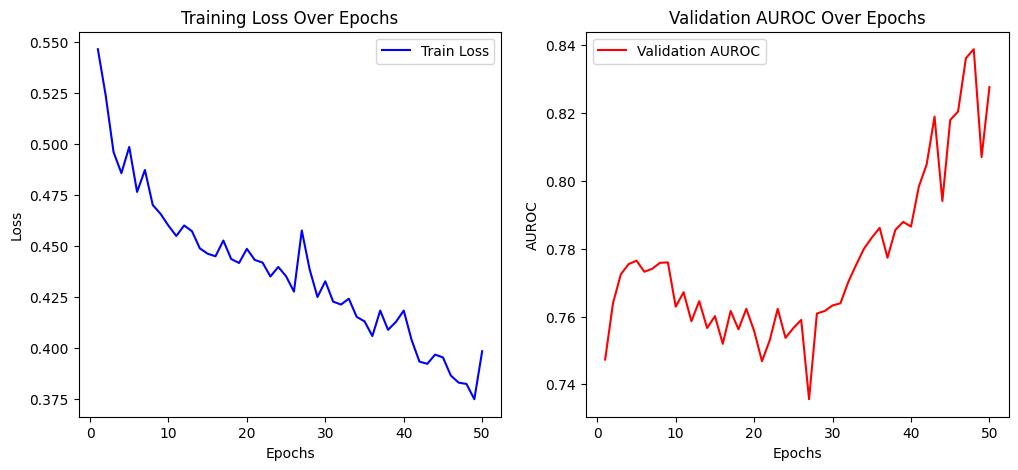

In [29]:
# TRAINING
num_epochs = 50
train_losses, val_aurocs = [], []

for epoch in range(1, num_epochs + 1):
    loss = train()
    val_auroc = compute_auroc(val_loader)
    train_losses.append(loss)
    val_aurocs.append(val_auroc)
    print(f"Epoch {epoch}: Loss={loss:.4f}, Validation AUROC={val_auroc:.4f}")




# Plot Training Loss and Validation AUROC
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", color='b')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

# AUROC plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_aurocs, label="Validation AUROC", color='r')
plt.xlabel("Epochs")
plt.ylabel("AUROC")
plt.title("Validation AUROC Over Epochs")
plt.legend()

plt.show()
